## Queries on CVE records for the extraction of IoT related referenced repositories:

In [ ]:
import collections
import pandas as pd
from matplotlib import pyplot as plt
import json 
import ast
import re
import os
import csv
import subprocess
import requests
import tempfile
from io import BytesIO, StringIO
from zipfile import ZipFile
from guesslang import Guess

In [ ]:
df = pd.read_csv('../data/cve-records.csv')
des_str = df['description'][0]

### Search Query: 
"Internet of Things" OR "IoT" OR "Industry 4.0" OR "smart cities" OR "smart city"OR "smart contract" OR "manufacturing" OR "energy" OR "supply chain" 

In [ ]:
def get_description(des_str):
    if des_str!=None or des_str!='':
        des_arr_dict = ast.literal_eval(des_str)
        des_cve = ""    #description of a CVE-> 'value' from array of dict.

        for dic in des_arr_dict:
            des_cve = des_cve + dic['value']
        return des_cve
        
    else:
        print('Empty description for CVE: ')
        return 0

def get_iot_cves(df):
    iot_set = ["Internet of Things", "IoT", "Industry 4.0", 
                "smart cities", "smart city", "smart contract", 
                "manufacturing", "energy", "supply chain", "orange pi", "banana pi", "arduino"]
    iot_cves = []

    for row in range(len(df)):
        des_cve = get_description(df['description'][row])
        
        # print if they are IoT related descriptions
        for x in iot_set:
            if x.lower() in des_cve.lower():
                # print(des_cve)
                # print(df['cve_id'][row])
                iot_cves.append(df['cve_id'][row])
                # print(df['reference_json'][row])
                # print('\n')
    return iot_cves

iot_cves = get_iot_cves(df)
print('count_cves:', len(iot_cves))

In [ ]:
df_iot = df[df.cve_id.isin(iot_cves)]
len(df_iot)

In [ ]:
iot_vcs = ['github', 'bitbucket', 'gitlab']
vcs_list = []

for ref_str in df_iot.reference_json:
    url_dict  = ast.literal_eval(ref_str)
    
    if len(url_dict) > 0:
        for ref in url_dict:
            vcs_list.append(ref['url'])     

## Vulnerabilty reporting databases and number of their occurances in CVEs

In [ ]:
url_freq = collections.Counter(url_heads)
df_url = pd.DataFrame(url_freq.items(), columns=['urls', 'count'])
df_url = df_url.sort_values(by=['count'], ascending=False)
df_url.to_csv('../result/top-databases.csv', index=False, sep=';')
df_url.head(5)

# Analysis of Infer output (report.json) file:

In [ ]:
import pandas as pd
import json
import os
import subprocess as sub
import time 

############################ Applying infer tool ############################

def json2df(file) -> pd.DataFrame:
    df = pd.DataFrame()
    with open(file) as f:
        data = json.load(f)
        df = pd.DataFrame(data)
    return df

def apply_infer(fname) -> pd.DataFrame:
    """find flaws in the file using infer tool"""
    infer_dir = 'infer-output'
    compiler = 'gcc'

    cmd = f"infer run --results-dir {infer_dir} -- {compiler} -c "
    out_file = f"{infer_dir}/report.json" # output file generated by infer tool

    df = pd.DataFrame() # dataframe to store the results

    if os.path.isfile(fname):
        cmd =  cmd + fname
        process = sub.Popen(
            cmd,
            shell=True,
            stdout=sub.PIPE,
        )
        process.wait() # wait for the process to finish
        
        # check if the output file is generated
        if os.path.isfile(out_file):
            df = json2df(out_file)
        if len(df)!=0:
            df["tool"] = "infer"
        df = df.reset_index(drop=True)

    else:
        print(f'Invalid command for infer tool! \
            \nPlease check the command again! \ncommand: {cmd}')
    return df

# fname = '../data/projects/contiki-2.4/tools/tunslip.c'
fname = '../data/projects/contiki-2.4/core/sys/timetable.c'

apply_infer(fname)

# Utilizing multiple CPU cores:

In [1]:
import multiprocessing

multiprocessing.cpu_count()

8

In [3]:
from multiprocessing import Pool

def f(x):
    return x*x

if __name__ == '__main__':
    with Pool(5) as p:
        print(p.map(f, [1, 2, 3]))

Process SpawnPoolWorker-1:
Traceback (most recent call last):
  File "/Users/guru/miniconda/envs/iotCode/lib/python3.8/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
  File "/Users/guru/miniconda/envs/iotCode/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/guru/miniconda/envs/iotCode/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/guru/miniconda/envs/iotCode/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'f' on <module '__main__' (built-in)>
Process SpawnPoolWorker-2:
Traceback (most recent call last):
  File "/Users/guru/miniconda/envs/iotCode/lib/python3.8/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
  File "/Users/guru/miniconda/envs/iotCode/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kw

In [29]:
from string import printable

printable.index('a')


10

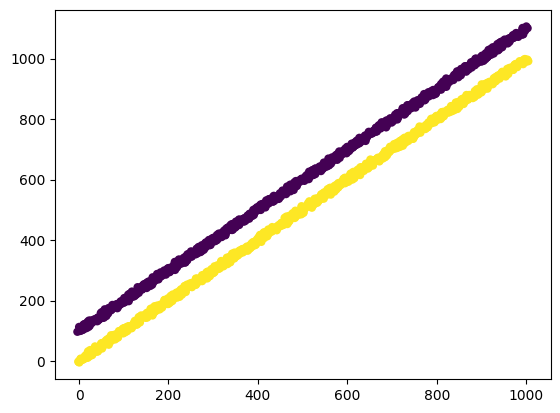

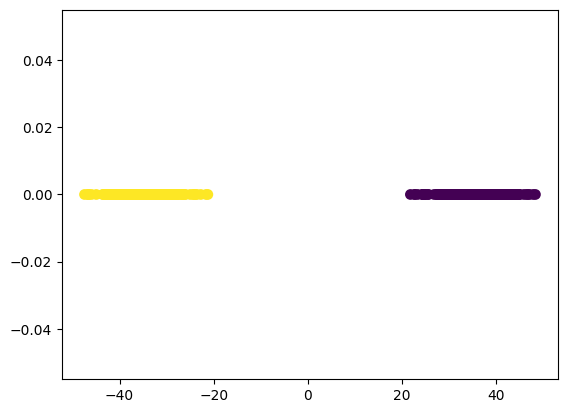

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer


def _generate_vector(shift=0.5, noise=15):
    return np.arange(1000) + (np.random.rand(1000) - shift) * noise


def generate_dataset():
    """
    This dataset is two lines with a slope ~ 1, where one has
    a y offset of ~100
    """
    return np.vstack((
        np.vstack((
            _generate_vector(),
            _generate_vector() + 100,
        )).T,
        np.vstack((
            _generate_vector(),
            _generate_vector(),
        )).T,
    )), np.hstack((np.zeros(1000), np.ones(1000)))


def all_but_first_column(X):
    return X[:, 1:]


def drop_first_component(X, y):
    """
    Create a pipeline with PCA and the column selector and use it to
    transform the dataset.
    """
    pipeline = make_pipeline(
        PCA(), FunctionTransformer(all_but_first_column),
    )
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    pipeline.fit(X_train, y_train)
    return pipeline.transform(X_test), y_test


if __name__ == '__main__':
    X, y = generate_dataset()
    lw = 0
    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], c=y, lw=lw)
    plt.figure()
    X_transformed, y_transformed = drop_first_component(*generate_dataset())
    plt.scatter(
        X_transformed[:, 0],
        np.zeros(len(X_transformed)),
        c=y_transformed,
        lw=lw,
        s=60
    )
    plt.show()


In [2]:
model_file = 'result/RNN-3-TinyVul-v2-function-binary-debug'

model = self.load_tf_model(model_file)

NameError: name 'self' is not defined